In [2]:
# install mujoco + robosuite
!apt-get install -y libglew-dev python-opengl ffmpeg
!pip install robosuite
!pip install mujoco
!apt-get update -y
!apt-get install -y ffmpeg
!pip install robosuite imageio

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
Reading package lists... Done
E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
W: Problem unlinking the file /var/cache/apt/pkgcache.bin - RemoveCaches (13: Permission denied)
W: Problem unlinking the file /var/cache/apt/srcpkgcache.bin - RemoveCaches (13: Permission denied)
N: Some sources can be modernized. Run 'apt modernize-sources' to do so.
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [3]:
import os
import numpy as np
import imageio
import robosuite as suite
from robosuite.controllers.composite.composite_controller_factory import load_composite_controller_config
import re
from typing import Sequence, Optional, Tuple

[robosuite WARNING] No private macro file found! (macros.py:53)
[robosuite WARNING] It is recommended to use a private macro file (macros.py:54)
[robosuite WARNING] To setup, run: python /home/cmuser/miniconda3/envs/dl-assign/lib/python3.10/site-packages/robosuite/scripts/setup_macros.py (macros.py:55)
[robosuite WARNING] Could not import robosuite_models. Some robots may not be available. If you want to use these robots, please install robosuite_models from source (https://github.com/ARISE-Initiative/robosuite_models) or through pip install. (__init__.py:30)
[robosuite WARNING] Could not load the mink-based whole-body IK. Make sure you install related import properly, otherwise you will not be able to use the default IK controller setting for GR1 robot. (__init__.py:40)


In [4]:
'''
Code in this cell is needed for preheat render. Otherwise, the camera image is buggy.
'''
# -------- Controller config --------
controller_config = load_composite_controller_config("BASIC", robot="Panda")

# -------- Create env (use default placement initializer) --------
env = suite.make(
    env_name="Lift",
    robots="Panda",
    has_renderer=False,
    has_offscreen_renderer=True,
    use_camera_obs=False,
    render_camera="frontview",
    controller_configs=controller_config,
)
obs = env.reset()

W, H = 640, 480
# physics preheat
for _ in range(10):
    env.step(np.zeros(7))

# render preheat
for _ in range(5):
    _ = env.sim.render(W, H, camera_name="frontview")
obs = env.reset()

[robosuite INFO] Loading controller configuration from: /home/cmuser/miniconda3/envs/dl-assign/lib/python3.10/site-packages/robosuite/controllers/config/default/composite/basic.json (composite_controller_factory.py:121)
[robosuite WARNING] The config has defined for the controller "left", but the robot does not have this component. Skipping, but make sure this is intended.Removing the controller config for left from self.part_controller_config. (robot.py:151)
[robosuite WARNING] The config has defined for the controller "torso", but the robot does not have this component. Skipping, but make sure this is intended.Removing the controller config for torso from self.part_controller_config. (robot.py:151)
[robosuite WARNING] The config has defined for the controller "head", but the robot does not have this component. Skipping, but make sure this is intended.Removing the controller config for head from self.part_controller_config. (robot.py:151)
[robosuite WARNING] The config has defined for

### End of setup code

---
---



### Create the robotic environment

[robosuite INFO] Loading controller configuration from: /home/cmuser/miniconda3/envs/dl-assign/lib/python3.10/site-packages/robosuite/controllers/config/default/composite/basic.json (composite_controller_factory.py:121)
[robosuite WARNING] The config has defined for the controller "left", but the robot does not have this component. Skipping, but make sure this is intended.Removing the controller config for left from self.part_controller_config. (robot.py:151)
[robosuite WARNING] The config has defined for the controller "torso", but the robot does not have this component. Skipping, but make sure this is intended.Removing the controller config for torso from self.part_controller_config. (robot.py:151)
[robosuite WARNING] The config has defined for the controller "head", but the robot does not have this component. Skipping, but make sure this is intended.Removing the controller config for head from self.part_controller_config. (robot.py:151)
[robosuite WARNING] The config has defined for

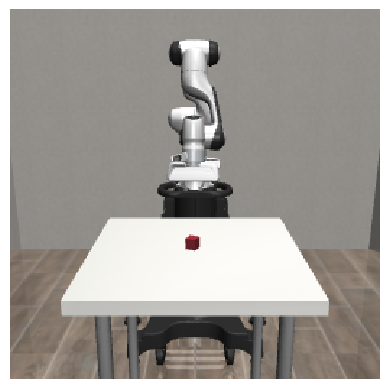

noisy: [ 0.00532384 -0.00903024  0.8308575 ]  true: [ 0.00532384 -0.00903024  0.8193208 ]


In [5]:
# create env
from utils import NoisyBlockObsWrapper, make_noisy_lift_env
env = make_noisy_lift_env(add_noise=False, image_size=(256, 256))
obs = env.reset()

import matplotlib.pyplot as plt
plt.imshow(obs["frontview_image"], interpolation="nearest")
plt.axis("off"); plt.show()

# show noisy obs and real b
noisy = obs["cube_pos_noisy"]
obs, r, d, info = env.step(np.zeros(env.action_dim))
print("noisy:", noisy, " true:", info["cube_pos_true"])

### Waypoint-based policy

In [7]:
from IPython.display import Video

from utils import (
    init_frames_dir,
    save_frame,
    step_with_action,
    move_ee_to,
    is_lift_success,
)


# --- Get image size from a fresh reset ---
obs = env.reset()
cam_name = "frontview"
cam_key = f"{cam_name}_image"
assert cam_key in obs, (
    f"Missing {cam_key} in obs. Make sure use_camera_obs=True and "
    f"camera_names includes '{cam_name}'."
)
cube_start_pos = np.asarray(obs["cube_pos_noisy"], dtype=float).copy()

H, W = obs[cam_key].shape[:2]  # Used later when exporting the video

# --- Prepare / clear frame directory ---
init_frames_dir("frames")

action_dim = env.action_dim
print("action_dim =", action_dim)

frame_id = 0

# --- Save first frame ---
frame_id = save_frame(obs, cam_key, frame_id, frames_dir="frames")


# --- Waypoint offsets in world frame ---
above_height = 0.15  # 15 cm above cube
grasp_height = 0.02  # (optional) fine adjustment
lift_height = 0.25   # lift height after grasp

# --- Build waypoints once from the noisy cube measurement ---
cube_pos_meas = np.asarray(obs["cube_pos_noisy"], dtype=float).copy()

target_above = cube_pos_meas.copy()
target_above[2] += above_height

target_grasp = cube_pos_meas.copy()
# target_grasp[2] += grasp_height  # enable if you want to offset the grasp height

target_lift = cube_pos_meas.copy()
target_lift[2] += lift_height

# ----------------------------------------------------------------
# Scripted policy: Above → Down → Close → Lift (using fixed noisy targets)
# ----------------------------------------------------------------

print("Phase 0: open gripper")
action_open = np.zeros(action_dim, dtype=float)
action_open[-1] = -1.0
obs, frame_id = step_with_action(
    env,
    action_open,
    n_steps=20,
    obs=obs,
    cam_key=cam_key,
    frame_id=frame_id,
    frames_dir="frames",
)

print("Phase 1: move above cube (noisy target)")
obs, frame_id = move_ee_to(
    env,
    obs,
    target_pos_or_fn=target_above,
    gripper=-1.0,
    steps=100,
    action_dim=action_dim,
    cam_key=cam_key,
    frame_id=frame_id,
    frames_dir="frames",
    kp=8.0,
    ki=0.0,
    kd=1.0,
    max_delta=0.1,
)

print("Phase 2: move down to grasp height (noisy target)")
obs, frame_id = move_ee_to(
    env,
    obs,
    target_pos_or_fn=target_grasp,
    gripper=-1.0,
    steps=250,
    action_dim=action_dim,
    cam_key=cam_key,
    frame_id=frame_id,
    frames_dir="frames",
    kp=[10.0, 10.0, 12.0],
    ki=0.0,
    kd=0.2,
    max_delta=0.1,
)

print("Phase 3: close gripper")
action_close = np.zeros(action_dim, dtype=float)
action_close[-1] = 1.0
obs, frame_id = step_with_action(
    env,
    action_close,
    n_steps=40,
    obs=obs,
    cam_key=cam_key,
    frame_id=frame_id,
    frames_dir="frames",
)

print("Phase 4: lift cube (noisy target)")
obs, frame_id = move_ee_to(
    env,
    obs,
    target_pos_or_fn=target_lift,
    gripper=1.0,
    steps=200,
    action_dim=action_dim,
    cam_key=cam_key,
    frame_id=frame_id,
    frames_dir="frames",
    kp=10.0,
    ki=0.0,
    kd=1.0,
    max_delta=0.1,
)

print("Phase 5: hold")
obs, frame_id = step_with_action(
    env,
    np.zeros(action_dim, dtype=float),
    n_steps=40,
    obs=obs,
    cam_key=cam_key,
    frame_id=frame_id,
    frames_dir="frames",
)

print("Scripted rollout finished. Frames saved to ./frames")

# --- Export video at native resolution (avoid scaling blur) ---
!ffmpeg -y -framerate 20 -i frames/frame_%04d.png -c:v libx264 -pix_fmt yuv420p controller_demo.mp4

# Inline preview (e.g., in Colab / Jupyter)
Video("controller_demo.mp4", embed=True, width=W)

[robosuite WARNING] The config has defined for the controller "left", but the robot does not have this component. Skipping, but make sure this is intended.Removing the controller config for left from self.part_controller_config. (robot.py:151)
[robosuite WARNING] The config has defined for the controller "torso", but the robot does not have this component. Skipping, but make sure this is intended.Removing the controller config for torso from self.part_controller_config. (robot.py:151)
[robosuite WARNING] The config has defined for the controller "head", but the robot does not have this component. Skipping, but make sure this is intended.Removing the controller config for head from self.part_controller_config. (robot.py:151)
[robosuite WARNING] The config has defined for the controller "base", but the robot does not have this component. Skipping, but make sure this is intended.Removing the controller config for base from self.part_controller_config. (robot.py:151)
[robosuite WARNING] Th

action_dim = 7
Phase 0: open gripper
Phase 1: move above cube (noisy target)
Phase 2: move down to grasp height (noisy target)
Phase 3: close gripper
Phase 4: lift cube (noisy target)
Phase 5: hold
Scripted rollout finished. Frames saved to ./frames
ffmpeg version 7.1.1-1ubuntu1.3 Copyright (c) 2000-2025 the FFmpeg developers
  built with gcc 14 (Ubuntu 14.2.0-19ubuntu2)
  configuration: --prefix=/usr --extra-version=1ubuntu1.3 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --disable-libmfx --disable-omx --enable-gnutls --enable-libaom --enable-libass --enable-libbs2b --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libharfbuzz --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-librubberband --

### Test whether the task is completed successfully.

In [8]:
success = is_lift_success(
    obs,
    cube_start_pos=cube_start_pos,
    min_lift=0.10,     # e.g., require 10 cm lift
    max_xy_shift=0.1, # allow up to 10 cm XY drift
    use_noisy=True,    # we are using noisy cube pos from wrapper
)

print("Lift success:", success)

Lift success: True
